# [7.4 Networks with Parallel Concatenations (GoogLeNet)](https://d2l.ai/chapter_convolutional-modern/googlenet.html)

paper : [Going Deeper with Convolutions (Szegedy et al. 2015)](https://ieeexplore.ieee.org/document/7298594)

## Inception block (v1)

- What's the best convolution kernel size to use when designing a network? We've seen then use of an 11x11 Conv kernel in **AlexNet**, 3x3 Conv kernels in **VGG**, 5x5 in **LeNet**, and 1x1 in **NiN**. Different kernel sizes explore the image at different extents. 


- The motivation behind the **inception network block** : just employ **convolutions with various kernel sizes**, **concatenate all the outputs**. Let the network to use all the information to determine which extracted features are more useful.

### Structure of the Inception block

<img src='./images/fig_7.4.1.png' width='550'/>

- The inception block consists of four parallel paths. It extracts information in parallel through convolutional layers of different window shapes and maximum pooling layers. 

- The middle two paths perform a **1x1 convolution** on the input to **reduce the number of channels**, reducing the model’s complexity. <br>
  c.f. In §7.3 Network-in-Network the 1x1 convolution layers are introduced in order to enhance model complexity by allowing interactions of cross channel information. 


- The four paths all use **appropriate padding** to give the input and output the same height and width.


- Finally, the outputs along each path are **concatenated along the channel dimension** and comprise the block’s output.

### Versions of Inception block network

#### Inception v2  : [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift -- Ioffe & Szegedy  2015](https://arxiv.org/abs/1502.03167)

- Adopt Batch normalization -> can train with higher learning rate. 
- Replace the 5x5 filter in Inception v1 by two 3x3 Conv layers.

#### Inception v3  : [Rethinking the Inception Architecture for Computer Vision -- Szegedy et al. 2015](https://arxiv.org/abs/1512.00567)

- Replace the 3x3 Conv by 1x3 and 3x1 Conv layers to further reduce number of parameters.

#### Inception v4  : [Inception-v4, Inception-ResNet and the Impact of Residual Connections on Learning -- Szegedy et al. 2016](https://arxiv.org/abs/1602.07261)

- Add residual connections


&emsp;&emsp;&emsp;&emsp;   <sub> * Reference : [Review: Inception-v4 — Evolved From GoogLeNet, Merged with ResNet Idea (Image Classification)](https://towardsdatascience.com/review-inception-v4-evolved-from-googlenet-merged-with-resnet-idea-image-classification-5e8c339d18bc) </sub>

## GoogLeNet (simplified version)

- Earlier layers similar to AlexNet & LeNet.

- A stack of a total of 9 inception blocks + global average pooling.

- Maximum pooling between inception blocks reduces the dimensionality.

- At the end, average pooling (avoids a stack of fully-connected layers) + 1 fully connected layer (to easily adapt the network to tasks with different number of classification labels).

<img src='./images/fig_7.4.2.png' width='350'/>

### GoogLeNet (original version)

- GoogLeNet has 22 layers. Training a deep network back in 2015 can be difficult.

- The original GoogLeNet model has some **side branches** (**auxiliary networks**) connected to the intermeidate layers to alliviate vanishing gradient problem and provide better regularization. 

- These side branches are ended with softmax activations in order to infer classification probabilities from intermediate features. During training, the loss from these side branches are added to the total loss of the network with some discount weights. This design helps the network to learn good intermediate features. 


## Implement Inception block in pytorch

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

## GoogLeNet

In [3]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [4]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [5]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [8]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
net.to(device)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [10]:
# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 5977530


In [11]:
### Load FashionMNIST dataset and apply data transform, make input dimension 28x28 -> 96x96

transform = transforms.Compose([transforms.Resize([96, 96]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))
images.shape

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([64, 1, 96, 96])

In [12]:
### Loss function
criterion = nn.CrossEntropyLoss()

In [13]:
### Optimizer
learning_rate = 0.001

# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [14]:
### Training function

def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [15]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    since = time.time()
    
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)
    
    time_elapsed = time.time() - since
    print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

>>> End epoch 1, train accuracy = 64.22%, train avgLoss = 0.9023
>>>              valid accuracy = 80.36%, valid avgLoss = 0.5305
	Time: 0m 45s
>>> End epoch 2, train accuracy = 83.38%, train avgLoss = 0.4456
>>>              valid accuracy = 84.76%, valid avgLoss = 0.4147
	Time: 0m 45s
>>> End epoch 3, train accuracy = 86.32%, train avgLoss = 0.3687
>>>              valid accuracy = 84.94%, valid avgLoss = 0.3950
	Time: 0m 45s
>>> End epoch 4, train accuracy = 87.54%, train avgLoss = 0.3312
>>>              valid accuracy = 88.40%, valid avgLoss = 0.3188
	Time: 0m 45s
>>> End epoch 5, train accuracy = 88.65%, train avgLoss = 0.3047
>>>              valid accuracy = 88.41%, valid avgLoss = 0.3155
	Time: 0m 45s
>>> End epoch 6, train accuracy = 89.22%, train avgLoss = 0.2880
>>>              valid accuracy = 89.15%, valid avgLoss = 0.3030
	Time: 0m 45s
>>> End epoch 7, train accuracy = 90.05%, train avgLoss = 0.2674
>>>              valid accuracy = 89.47%, valid avgLoss = 0.2839
	Time:

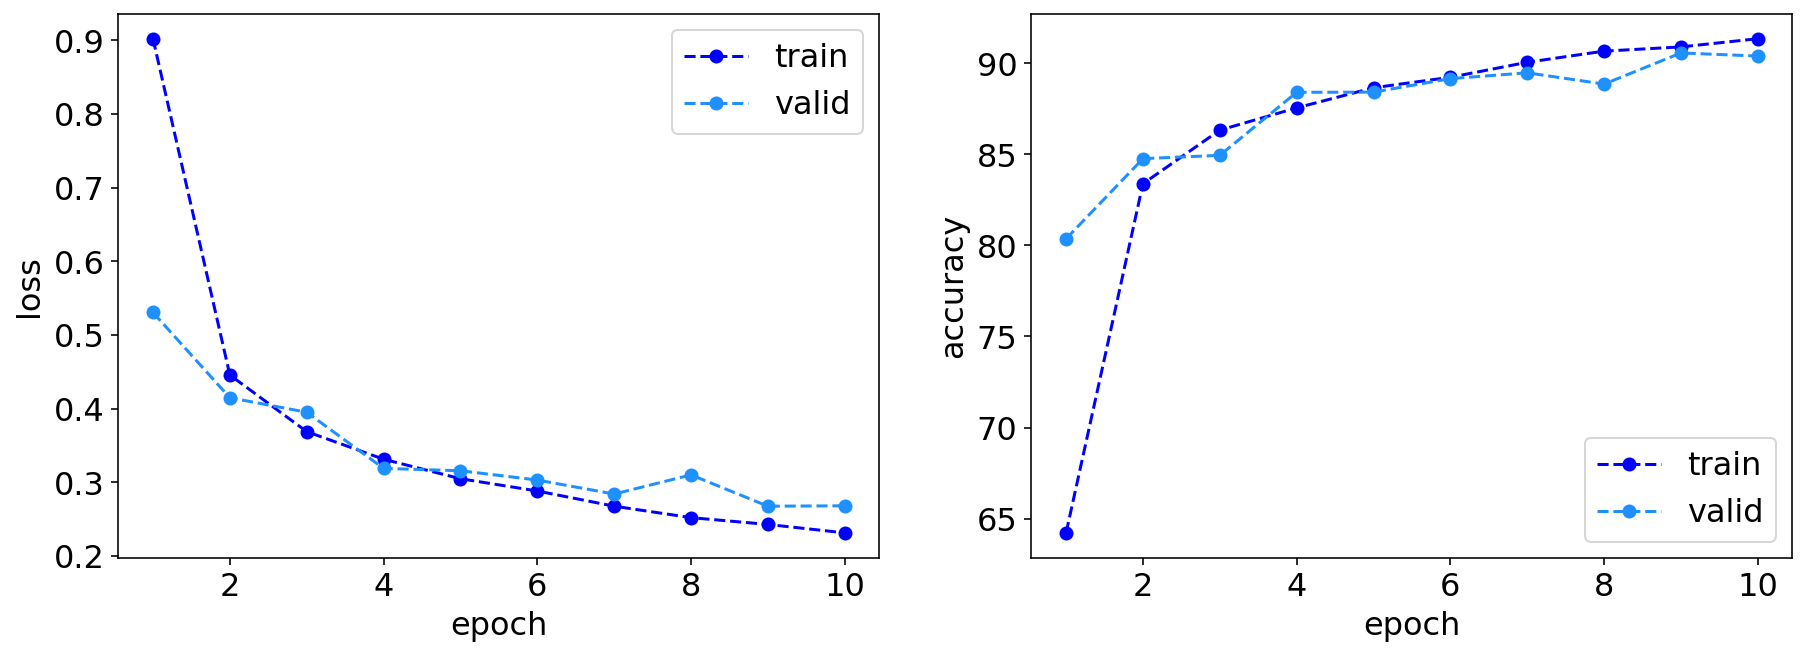

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')